# Lifecycle investing: a statistical approach

This work is reproducing the approach to lifecycle investing using different statistical techniques. In traditional lifecycle investing numerical dynamic programming (NDP) is used to optimize for the consumption of the agent and derive the optimal asset allocation trough time. In our approach we use instead neural networks to derive it.

## Lifecycle Investing

Description of Lifecycle Investing, definition of parameters used, current approach to the solution

The utility function we are optimizing is:

$$V_t = \left\{ \left( 1 - \delta \right)C_t^{1-1/\psi} + \delta E_t\left[ p_tV_{t+1}^{1-\gamma} \right]^{\frac{1-1/\psi}{1 - \gamma}} \right\}^{\frac{1}{1 - 1/\psi}}$$

When the bequest motive is equal to 0.

In [14]:
import pandas as pd
import numpy as np
import math
from scipy.optimize import minimize

# Hyperparameters
start_age = 20
end_age = 115
initial_income = 1
last_consumption = 0.1
income_volatility = 0.05
risk_asset_average_return = 0.05
risk_asset_volatility = 0.2
risk_free_return = 0.02
delta = 0.96
psi = 0.1
gamma = 3
survival_probability = [0.99] * 115
retirement_age = 70
min_equity = 0.2

# For recording metrics
all_epochs = []
income_distribution_list = []
return_distribution_list = []
consumed_wealth_list = []
equity_allocation_ts_list = []
utility_ts_list = []

def epstein_zin_utility(x, wealth, age, future_utility):
    total_return = x[1] * risk_asset_return[age] + (1 - x[1]) * risk_free_return
    new_wealth = (wealth + income[age] - x[0]) * np.exp(total_return)
    # I am really not sure about this line, I should probably use the interpolated_future_utility
    expected_future_value = new_wealth
    # I need to add the bequest motive
    expected_future_utility = survival_probability[age] * future_utility ** (1 - gamma)
    value = ((((1 - delta) * x[0] ** (1 - 1 / psi)) + 
            ((delta * expected_future_utility) ** ((1 - 1 / psi) / (1 - gamma)))) ** 
            (1 / (1 - 1 / psi)))
    return value

for i in range(1, 100):
    income = [0] * start_age
    risk_asset_return = [0] * start_age
    consumed_wealth = []
    equity_allocation_ts = []
    permanent_income = []
    enne_list = []
    utility_ts = []
    P_t = np.random.normal(scale = income_volatility)
    
    # I use this loop to generate the income and the returns
    for current_age in range(start_age, end_age):
        risk_asset_return.append(np.random.normal(loc = risk_asset_average_return,
                                                  scale = risk_asset_volatility))
        if (current_age < retirement_age):
            income.append(math.exp(initial_income + P_t + np.random.normal(scale = income_volatility)))
        else:
            income.append(0)                                     
        enne_t = np.random.normal(scale = income_volatility)
        permanent_income.append(P_t)
        P_t = P_t + enne_t
        enne_list.append(enne_t)
        # I need to introduce retirement income here too

    consumption = last_consumption
    wealth = consumption
    vtplus1 = ((1 - delta) * wealth ** (1 - 1 / psi)) ** (1 / (1- 1 / psi))
    utility = vtplus1
    utility_ts.append(utility)
    consumed_wealth.append(consumption)
    equity_allocation_ts.append(0)
    fun = lambda x: -epstein_zin_utility(x, wealth, 114, utility)
    res = minimize(
        fun,
        [wealth / 2, 0.99],
        method = 'SLSQP',
        bounds=[(0, wealth), (min_equity, 1)],
        )
    consumption = res.x[0]
    equity_allocation = res.x[1]
    utility = np.abs(res.fun)
    utility_ts.append(utility)
    consumed_wealth.append(consumption)
    equity_allocation_ts.append(equity_allocation)
    # I use this loop to reverse-solve the problem
    for current_age in range(end_age - 1, start_age, -1):
        fun = lambda x: -epstein_zin_utility(x, wealth, current_age, utility)
        res = minimize(
            fun,
            [wealth / 2, 0.99],
            method = 'SLSQP',
            bounds=[(0, wealth), (min_equity, 1)],
            )
        consumption = res.x[0]
        equity_allocation = res.x[1]
        utility = np.abs(res.fun)
        wealth = utility
        utility_ts.append(utility)
        consumed_wealth.append(consumption)
        equity_allocation_ts.append(equity_allocation)
        # consumed_wealth.append(consumption)

    income_distribution_list.append(income)
    return_distribution_list.append(risk_asset_return)
    utility_ts.reverse()
    utility_ts_list.append(utility_ts)
    consumed_wealth.reverse()
    consumed_wealth_list.append(consumed_wealth)
    equity_allocation_ts.reverse()
    equity_allocation_ts_list.append(equity_allocation_ts)

print("Training finished.")

C:\Users\AS\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
C:\Users\AS\AppData\Local\Temp/ipykernel_9708/3979878159.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  value = ((((1 - delta) * x[0] ** (1 - 1 / psi)) +
C:\Users\AS\AppData\Local\Temp/ipykernel_9708/3979878159.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  expected_future_utility = survival_probability[age] * expected_future_value ** (1 - gamma)


Training finished.


<AxesSubplot:>

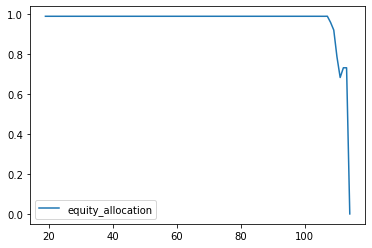

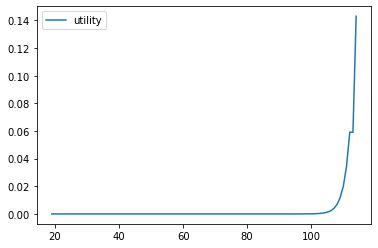

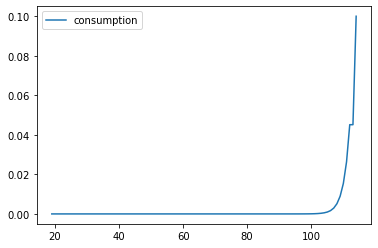

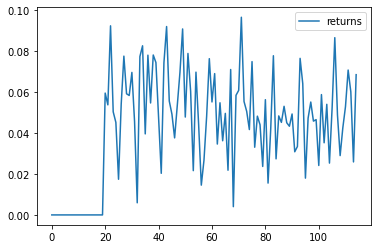

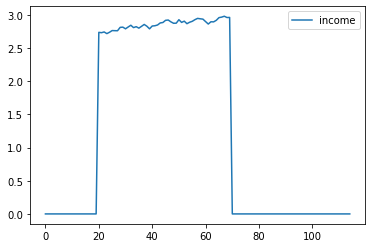

In [15]:
pd.DataFrame(np.mean(np.array(equity_allocation_ts_list), axis=0), 
    index = range(start_age - 1, end_age),
    columns=["equity_allocation"]).plot()
pd.DataFrame(np.mean(np.array(utility_ts_list), axis=0), 
    index = range(start_age - 1, end_age),
    columns=["utility"]).plot()
pd.DataFrame(np.mean(np.array(consumed_wealth_list), axis=0), 
    index = range(start_age - 1, end_age),
    columns=["consumption"]).plot()
pd.DataFrame(np.mean(np.array(return_distribution_list), axis=0), 
    index = range(0, end_age),
    columns=["returns"]).plot()
pd.DataFrame(np.mean(np.array(income_distribution_list), axis=0), 
    index = range(0, end_age),
    columns=["income"]).plot()